**About** : This notebook is used for 3D segmentation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/workspace/kaggle_rsna_abdominal/src


## Initialization

### Imports

In [3]:
import os
import torch

print(torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.cuda.get_device_name(0)
print(device)

2.1.0a0+29c30b1
Tesla V100-SXM2-32GB-LS


In [4]:
import os
import re
import sys
import glob
import json
import time
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import *

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [5]:
from params import *
from data.dataset import *
from data.preparation import *
from data.transforms import get_transfos

from model_zoo.models_seg import define_model, convert_3d
from training.main_seg import k_fold
from inference.extract_features import Config

from util.plots import *

In [6]:
from model_zoo.models_seg import define_model
from util.torch import load_model_weights
from training.losses import SegLoss

## Preparation
- Or download the data from

In [7]:
df_patient, df_img = prepare_data(DATA_PATH)

In [8]:
series = df_img.groupby('series')[['patient_id', "frame"]].max().reset_index()

segs = pd.DataFrame({"path": glob.glob("../input/segmentations/*.nii")})
segs['series'] = segs['path'].apply(lambda x: int(x.split('/')[-1][:-4]))
segs = segs.merge(series)
segs = segs[["patient_id", "series", "frame", "path"]]

In [13]:
SAVE_FOLDER = "../input/3ds/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

MAX_LEN = 600
SIZE = 256

SAVE = False
PLOT = True

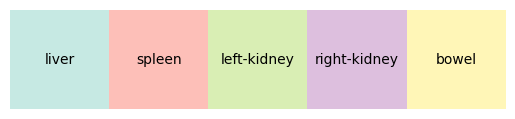

  0%|          | 0/206 [00:00<?, ?it/s]

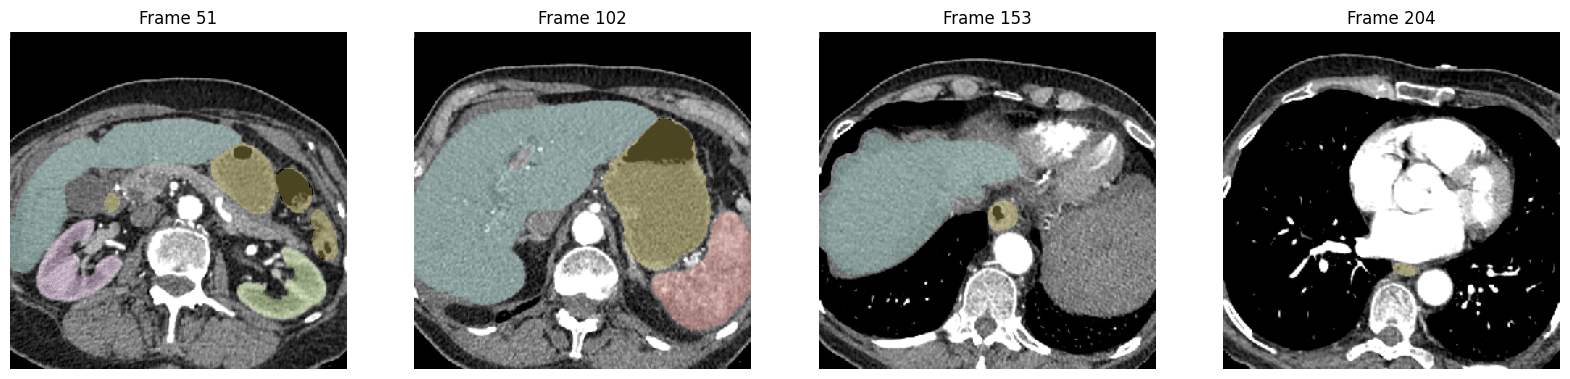

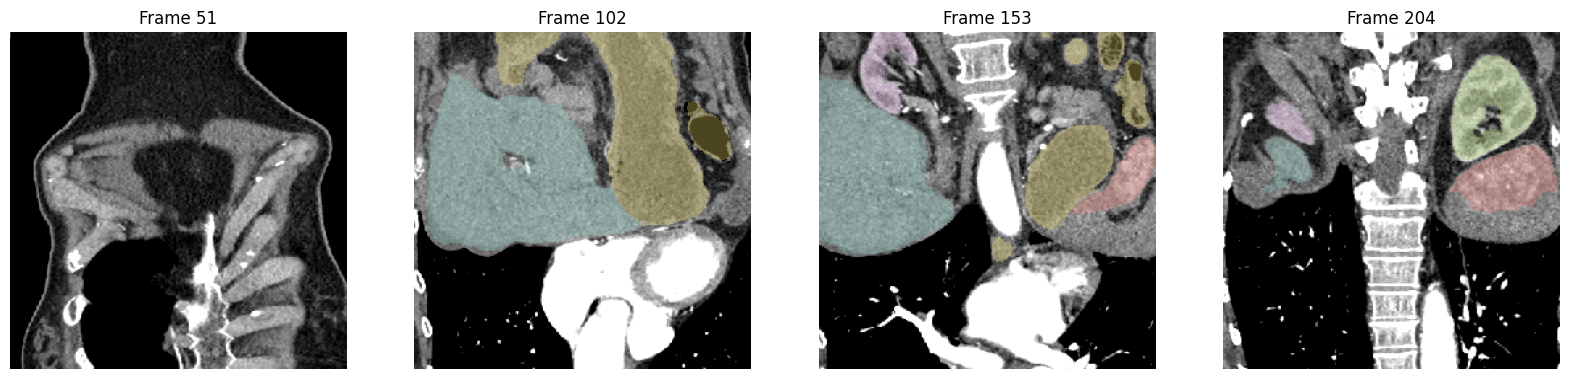

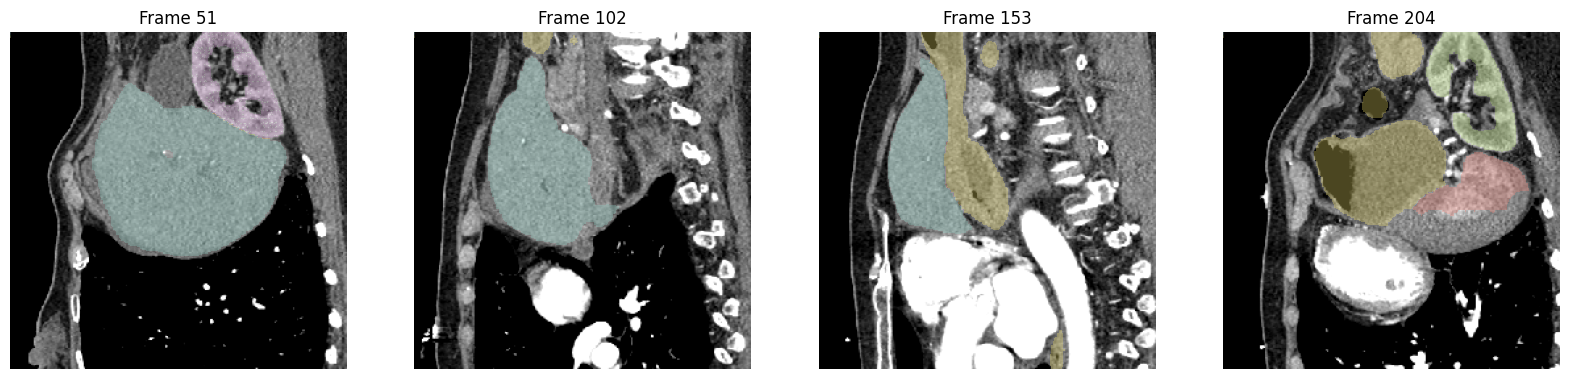

  0%|          | 0/206 [00:06<?, ?it/s]

CPU times: user 7.04 s, sys: 1.5 s, total: 8.54 s
Wall time: 7.04 s


In [14]:
%%time
if PLOT:
    show_cmap()

for idx in tqdm(range(len(segs))):
    patient_id = segs['patient_id'][idx]
    series = segs['series'][idx]

    imgs = sorted(glob.glob("../input/imgs/" + f"{patient_id}_{series}_*"))
    imgs = np.array([cv2.imread(f, 0) for f in imgs[-MAX_LEN:]])
    imgs = center_crop_pad(imgs, 384)

    imgs = F.interpolate(torch.from_numpy(imgs).unsqueeze(0).unsqueeze(0), size=(SIZE, SIZE, SIZE), mode="nearest")[0][0]
    
    imgs = imgs.numpy().astype(np.uint8)
    
    seg = load_segmentation(segs['path'][idx])[-MAX_LEN:]
    seg = center_crop_pad(seg, 384).copy()
    
    seg = F.interpolate(torch.from_numpy(seg).unsqueeze(0).unsqueeze(0), size=(SIZE, SIZE, SIZE), mode="nearest")[0][0]
    seg = seg.numpy().astype(np.uint8)
    
    if SAVE:
        np.save(SAVE_FOLDER + "imgs/" + f"{patient_id}_{series}.npy", imgs)
        np.save(SAVE_FOLDER + "segs/" + f"{patient_id}_{series}.npy", seg)
    
    if PLOT:
        ids = [i * len(imgs) // 5 for i in range(1, 5)]
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[id_], seg[id_])
            plt.title(f'Frame {id_}')
        plt.show()
        
        ids = [i * imgs.shape[1] // 5 for i in range(1, 5)]
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[:, id_], seg[:, id_])
            plt.title(f'Frame {id_}')
        plt.show()
        
        ids = [i * imgs.shape[2] // 5 for i in range(1, 5)]
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[:, :, id_], seg[:, :, id_])
            plt.title(f'Frame {id_}')
        plt.show()
#         if idx > 10:
    break

In [15]:
df_seg = pd.DataFrame({
    "mask_path": sorted(glob.glob(f'{SAVE_FOLDER}/segs/*.npy'))
})
df_seg['patient_id'] = df_seg['mask_path'].apply(lambda x: int(x.split('/')[-1].split('_')[0]))
df_seg['series'] = df_seg['mask_path'].apply(lambda x: int(x.split('/')[-1].split('_')[1][:-4]))

df_seg['img_path'] = df_seg['mask_path'].apply(lambda x: re.sub("/segs/", "/imgs/", x))
df_seg = df_seg[["patient_id", "series", "img_path", "mask_path"]]

# df_seg.to_csv('../input/df_seg_3d.csv', index=False)
df_seg.head()

patient_id  series                            img_path                           mask_path
0       10004   21057  ../input/3ds//imgs/10004_21057.npy  ../input/3ds//segs/10004_21057.npy
1       10004   51033  ../input/3ds//imgs/10004_51033.npy  ../input/3ds//segs/10004_51033.npy
2       10217   16066  ../input/3ds//imgs/10217_16066.npy  ../input/3ds//segs/10217_16066.npy
3       10228   30522  ../input/3ds//imgs/10228_30522.npy  ../input/3ds//segs/10228_30522.npy
4       10228   40471  ../input/3ds//imgs/10228_40471.npy  ../input/3ds//segs/10228_40471.npy

## Train Your model !

- Using `bash seg_cls.sh`

## 3D Inference

In [16]:
EXP_FOLDER = "../logs/2023-09-24/20/"  # YOUR TRAINED MODEL
SAVE_FOLDER = "../input/3ds/"

os.makedirs(EXP_FOLDER + "masks/", exist_ok=True)

In [17]:
config = Config(json.load(open(EXP_FOLDER + "config.json", "r")))

In [18]:
df_patient, df_img = prepare_data(DATA_PATH)

In [19]:
df_series = df_img[["patient_id", 'series', 'frame']].groupby(["patient_id", 'series']).max().reset_index()

folds = pd.read_csv("../input/folds_4.csv")
df_series = df_series.merge(folds, how="left")

In [20]:
PLOT = True
SAVE = False

model.safetensors:   0%|          | 0.00/46.9M [00:00<?, ?B/s]


 -> Loading encoder weights from ../logs/2023-09-24/20/resnet18d_0.pt



  0%|          | 0/10 [00:00<?, ?it/s]

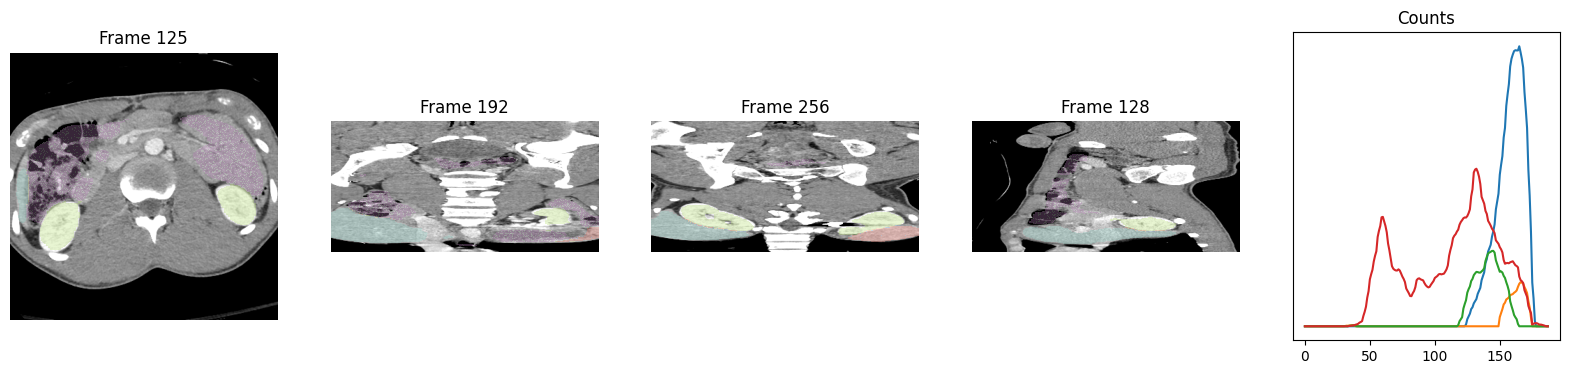

  0%|          | 0/10 [00:05<?, ?it/s]

CPU times: user 9.26 s, sys: 1.51 s, total: 10.8 s
Wall time: 7.69 s


In [21]:
%%time
for fold in range(4):
# for fold in [0]:
    df_seg = df_series[df_series['fold'] == fold].reset_index(drop=True).head(10)

    model = define_model(
        config.decoder_name,
        config.name,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        increase_stride=config.increase_stride,
    )

    model = convert_3d(model)
    model = load_model_weights(model, EXP_FOLDER + f"{config.name}_{fold}.pt")
    model = model.cuda()
    
    for idx in tqdm(range(len(df_seg))):
        patient_id = df_seg['patient_id'][idx]
        series = df_seg['series'][idx]
        n_frames = df_seg['frame'][idx]

        imgs = sorted(glob.glob("../input/imgs/" + f"{patient_id}_{series}_*"))
        imgs = np.array([cv2.imread(f, 0) for f in imgs[-MAX_LEN:]])
        n_frames = int(len(imgs))
        imgs = center_crop_pad(imgs, 384)

        x = torch.from_numpy(imgs).cuda().float() / 255.
        
        with torch.cuda.amp.autocast(enabled=True):
            x = x.unsqueeze(0).unsqueeze(0)
            x = F.interpolate(x, size=(SIZE, SIZE, SIZE), mode="nearest")

            pred = model(x)[0].argmax(1, keepdims=True).float()
            pred = F.interpolate(pred, size=(n_frames, 384, 384), mode="nearest")
            
        msk = pred.cpu().numpy()[0][0].astype(int)
        
        assert msk.shape == imgs.shape
        
        counts = np.array([(msk == i).sum(-1).sum(-1) for i in range(1, 5)])

        if SAVE:
            np.save(EXP_FOLDER + "masks/" + f"mask_{patient_id}_{series}.npy", msk.astype(np.uint8))
            np.save(EXP_FOLDER + "masks/" + f"mask_counts_{patient_id}_{series}.npy", counts.astype(int))

        if PLOT or not (idx % 100):
            plt.figure(figsize=(20, 4))
            ids = [i * n_frames // 6 for i in range(1, 5)]

            plt.subplot(1, 5, 1)
            plot_mask(imgs[ids[-1]], msk[ids[-1]])
            plt.title(f'Frame {ids[-1]}')
            
            ids = [i * 384 // 6 for i in range(1, 5)]

            plt.subplot(1, 5, 2)
            plot_mask(imgs[:, ids[2]], msk[:, ids[2]])
            plt.title(f'Frame {ids[2]}')
            
            plt.subplot(1, 5, 3)
            plot_mask(imgs[:, ids[3]], msk[:, ids[3]])
            plt.title(f'Frame {ids[3]}')

            plt.subplot(1, 5, 4)
            plot_mask(imgs[:, :, ids[1]], msk[:, :, ids[1]])
            plt.title(f'Frame {ids[1]}')

            plt.subplot(1, 5, 5)
            plt.plot(counts.T)
            plt.yticks([], [])
            plt.title(f'Counts')
            
            plt.show()

#         if idx > 5:
#         break
#     break

In [22]:
# %%time

# df_img = pd.DataFrame({"path": sorted(glob.glob("../input/imgs/*"))})
# df_img['series'] = df_img['path'].apply(lambda x: x.split('_')[-2])
# d = df_img.groupby('series').agg(list)[['path']].to_dict()['path']

In [23]:
# %%time
# for fold in [0]:
#     df_seg = df_series[df_series['fold'] == fold].reset_index(drop=True)

#     for idx in tqdm(range(len(df_seg))):
#         patient_id = df_seg['patient_id'][idx]
#         series = df_seg['series'][idx]

#         imgs = sorted(d[str(series)])[-MAX_LEN:]

#         msk = np.load(EXP_FOLDER + "masks/" + f"mask_{patient_id}_{series}.npy")
#         for i, m in enumerate(msk):
#             frame = imgs[i].split('_')[-1][:4]
#             cv2.imwrite(EXP_FOLDER + "masks/" + f"mask_{patient_id}_{series}_{frame}.png", m)
# #         break
# #     break

### Generate crops

In [24]:
from util.plots import plot_mask
from matplotlib.patches import Rectangle

In [30]:
df_patient, df_img = prepare_data(DATA_PATH)

In [25]:
MASK_FOLDER = "../logs/2023-09-24/20/masks/"  # YOUR TRAINED MODEL
IMG_PATH = "../input/imgs/"

MAX_LEN = 600
MARGIN = 5

PLOT = True
SAVE = False

In [26]:
df_series = df_img[['patient_id', "series", "frame"]].groupby(['patient_id', "series"]).max().reset_index()

In [27]:
def get_start_end(x):
    return np.argmax(x), len(x) - np.argmax(x[::-1])

In [28]:
SAVE_FOLDER = "../input/crops/"
SAVE_FOLDER_IMG = SAVE_FOLDER + "imgs_bowel/"
SAVE_FOLDER_MASK = SAVE_FOLDER + "masks_bowel/"

os.makedirs(SAVE_FOLDER, exist_ok=True)
os.makedirs(SAVE_FOLDER_IMG, exist_ok=True)
os.makedirs(SAVE_FOLDER_MASK, exist_ok=True)

  0%|          | 0/4711 [00:00<?, ?it/s]

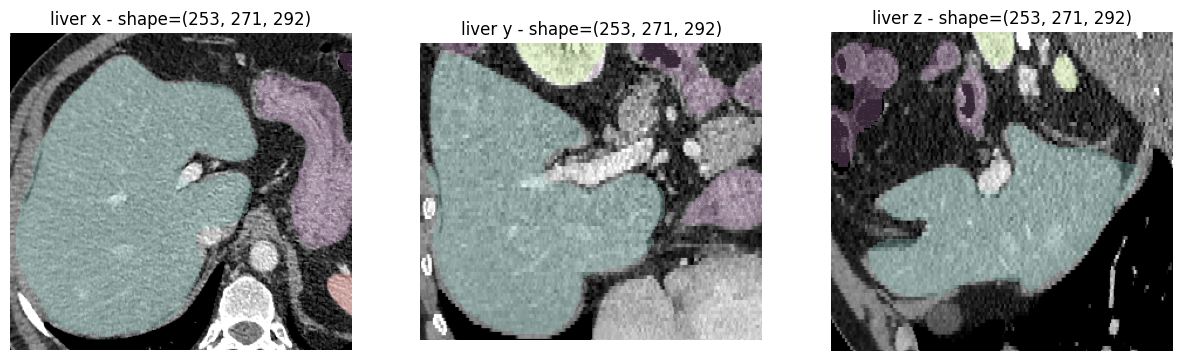

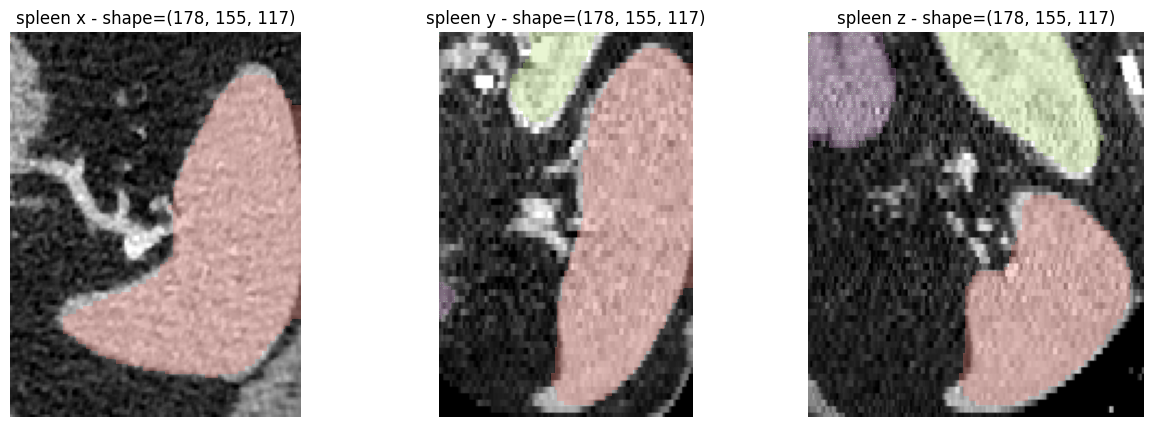

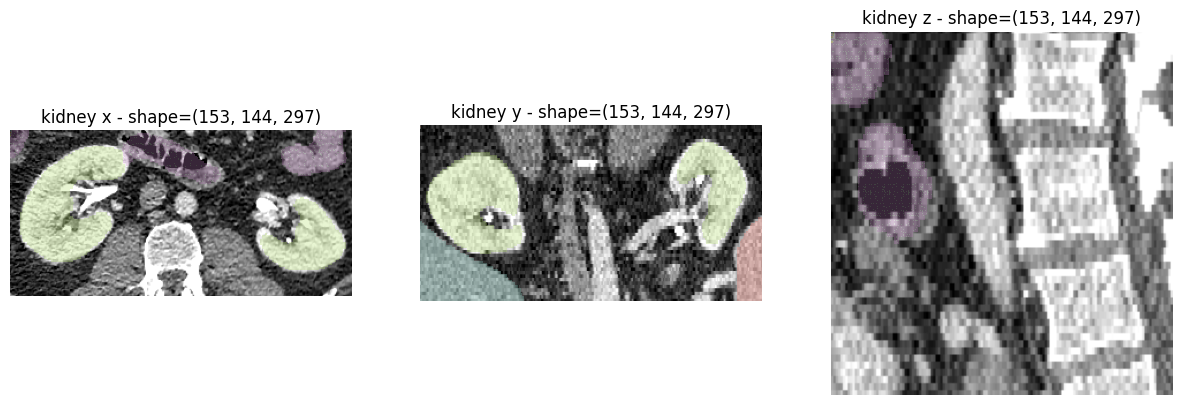

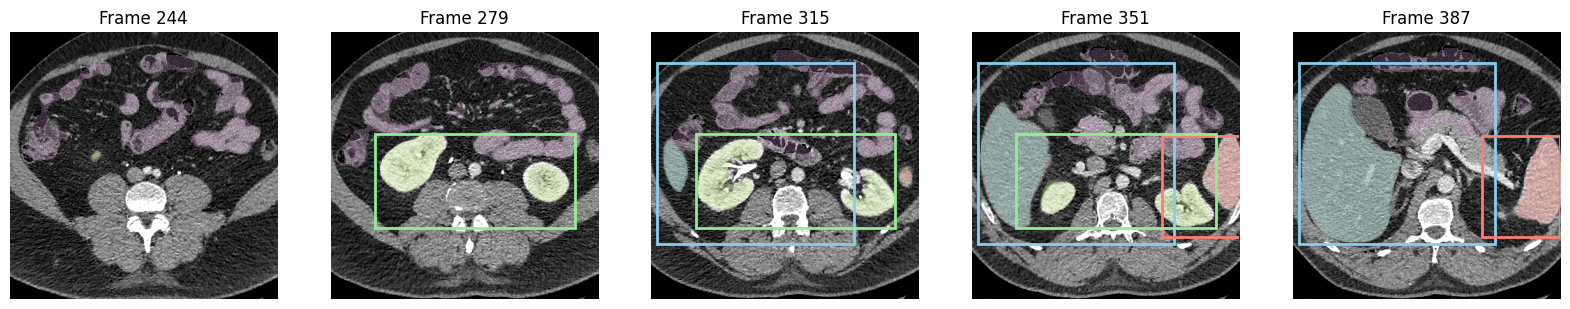

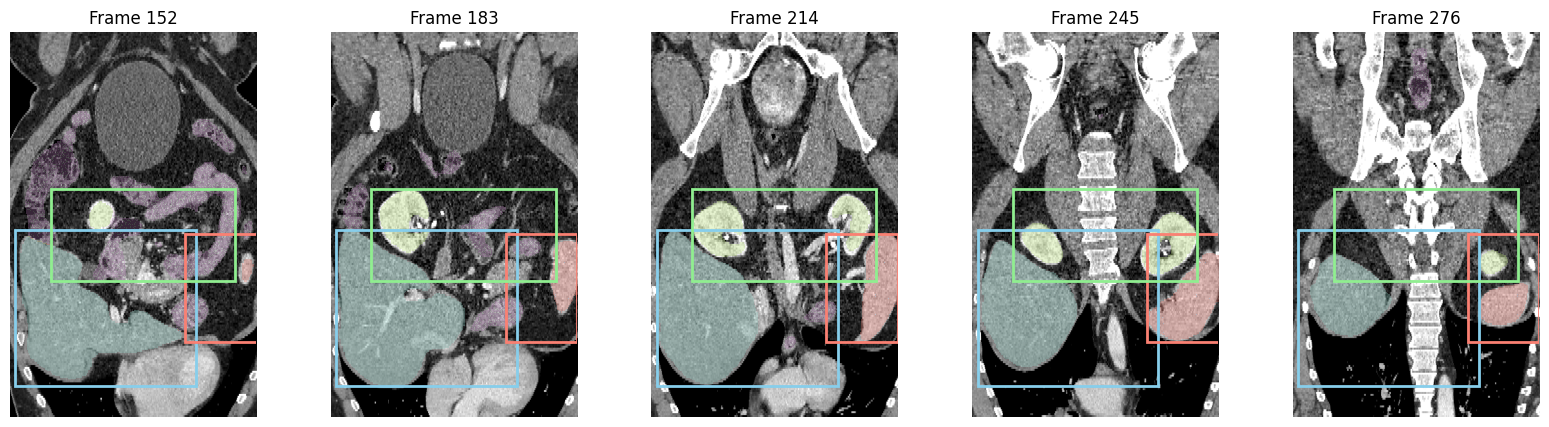

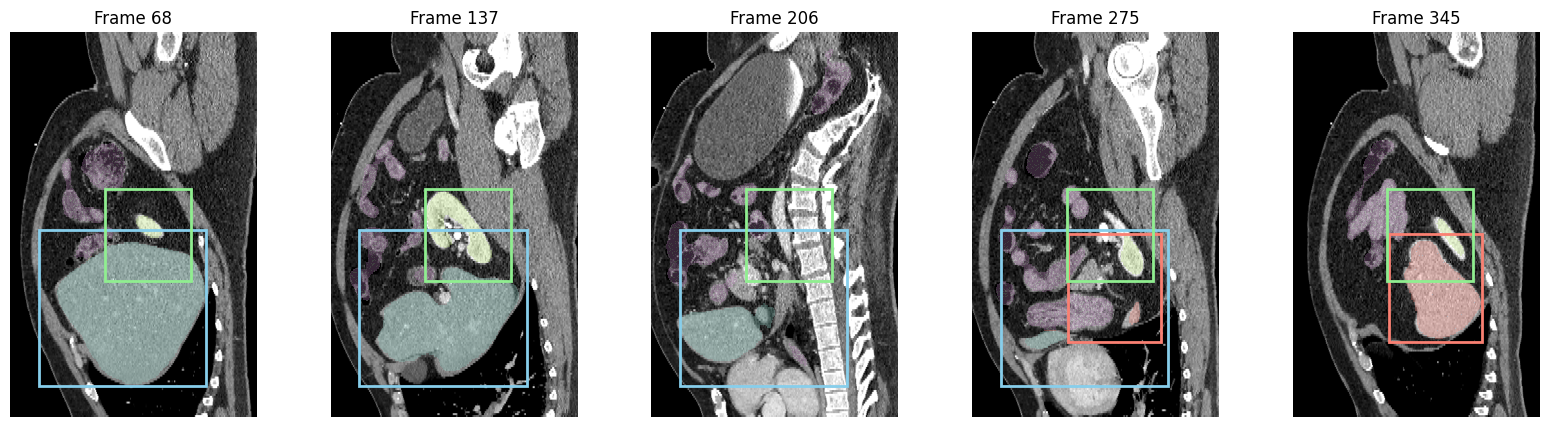

  0%|          | 0/4711 [00:09<?, ?it/s]


In [31]:
for i in tqdm(range(len(df_series))):
    mask_path = f'mask_{df_series.patient_id[i]}_{df_series.series[i]}.npy'
    seg = np.load(MASK_FOLDER + mask_path)

    imgs = np.concatenate([
         cv2.imread(
            IMG_PATH + f'{df_series.patient_id[i]}_{df_series.series[i]}_{f:04d}.png'
        ) for f in range(0, df_series['frame'][i], 3)
    ], -1).transpose(2, 0, 1)[-MAX_LEN:]
    imgs = center_crop_pad(imgs, 384)

    liver = (seg == 1).astype(np.uint8)
    spleen = (seg == 2).astype(np.uint8)
    kidney = (seg == 3).astype(np.uint8)
    
    x0_liver, x1_liver = get_start_end(liver.sum((1, 2)) > 400)
    y0_liver, y1_liver = get_start_end(liver.sum((0, 2)) > 400)
    z0_liver, z1_liver = get_start_end(liver.sum((0, 1)) > 400)
    
    x0_spleen, x1_spleen = get_start_end(spleen.sum((1, 2)) > 100)
    y0_spleen, y1_spleen = get_start_end(spleen.sum((0, 2)) > 100)
    z0_spleen, z1_spleen = get_start_end(spleen.sum((0, 1)) > 100)
    
    x0_kidney, x1_kidney = get_start_end(kidney.sum((1, 2)) > 100)
    y0_kidney, y1_kidney = get_start_end(kidney.sum((0, 2)) > 100)
    z0_kidney, z1_kidney = get_start_end(kidney.sum((0, 1)) > 100)
    
    x0s = [x0_liver, x0_spleen, x0_kidney]
    x1s = [x1_liver, x1_spleen, x1_kidney]
    y0s = [y0_liver, y0_spleen, y0_kidney]
    y1s = [y1_liver, y1_spleen, y1_kidney]
    z0s = [z0_liver, z0_spleen, z0_kidney]
    z1s = [z1_liver, z1_spleen, z1_kidney]
    cs = ["skyblue", "salmon", "lightgreen"]
    
    for x0, x1, y0, y1, z0, z1, name in zip(x0s, x1s, y0s, y1s, z0s, z1s, ['liver', 'spleen', 'kidney']):
        x0, x1 = max(0, x0 - MARGIN), min(imgs.shape[0], x1 + MARGIN)
        y0, y1 = max(0, y0 - MARGIN), min(imgs.shape[1], y1 + MARGIN)
        z0, z1 = max(0, z0 - MARGIN), min(imgs.shape[2], z1 + MARGIN)
        
        img_crop = imgs[x0: x1, y0:y1, z0:z1]
        seg_crop = seg[x0: x1, y0:y1, z0:z1]
        
        if PLOT or not (i % 1000):
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            id_ = img_crop.shape[0] // 2
            plot_mask(img_crop[id_], seg_crop[id_])
            plt.title(f'{name} x - shape={img_crop.shape}')
            plt.subplot(1, 3, 2)
            id_ = img_crop.shape[1] // 2
            plot_mask(img_crop[:, id_], seg_crop[:, id_])
            plt.title(f'{name} y - shape={img_crop.shape}')
            plt.subplot(1, 3, 3)
            id_ = img_crop.shape[2] // 2
            plot_mask(img_crop[:, :, id_], seg_crop[:, :, id_])
            plt.title(f'{name} z - shape={img_crop.shape}')
            plt.show()

        if SAVE:
            np.save(SAVE_FOLDER_IMG + f'{df_series.patient_id[i]}_{df_series.series[i]}_{name}.npy', img_crop)
            np.save(SAVE_FOLDER_MASK + f'{df_series.patient_id[i]}_{df_series.series[i]}_{name}.npy', seg_crop)

    if PLOT or not (i % 1000):
        ids = np.linspace(x0 + 5, x1 - 5, 5, dtype=int)
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[id_], seg[id_])
            plt.title(f'Frame {id_}')
            
            for x0, x1, y0, y1, z0, z1, col in zip(x0s, x1s, y0s, y1s, z0s, z1s, cs):
                rect = Rectangle(
                    (z0, y0),
                    z1 - z0,
                    y1 - y0,
                    linewidth=2,
                    facecolor="none",
                    edgecolor=col,
                )
                if id_ > x0 and id_ < x1:
                    plt.gca().add_patch(rect)
        plt.show()
        
        ids = np.linspace(y0 + 5, y1 - 5, 5, dtype=int)
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[:, id_], seg[:, id_])
            plt.title(f'Frame {id_}')
            
            for x0, x1, y0, y1, z0, z1, col in zip(x0s, x1s, y0s, y1s, z0s, z1s, cs):
                rect = Rectangle(
                    (z0, x0),
                    z1 - z0,
                    x1 - x0,
                    linewidth=2,
                    facecolor="none",
                    edgecolor=col,
                )
                if id_ > y0 and id_ < y1:
                    plt.gca().add_patch(rect)
        plt.show()
        
        ids = np.linspace(z0 + 5, z1 - 5, 5, dtype=int)
        plt.figure(figsize=(20, 5))
        for i, id_ in enumerate(ids):
            plt.subplot(1, len(ids), i + 1)
            plot_mask(imgs[:, :, id_], seg[:, :, id_])
            plt.title(f'Frame {id_}')
            for x0, x1, y0, y1, z0, z1, col in zip(x0s, x1s, y0s, y1s, z0s, z1s, cs):
                rect = Rectangle(
                    (y0, x0),
                    y1 - y0,
                    x1 - x0,
                    linewidth=2,
                    facecolor="none",
                    edgecolor=col,
                )
                if id_ > z0 and id_ < z1:
                    plt.gca().add_patch(rect)
        plt.show()
        
#     break

Done ! 